#### **Using Implied Cost of Capital as a Sector ETF Valuation Tool**
#### _[Sunday 5.24.2015]_
------------

***This is a follow-up to these posts [here](http://blkarb.se/1FCBL1R) and [here](http://blkarb.se/1HJ3tsR) where I detail the `ICC` methodology used. All the data and plots have been updated and reflects current information. Scroll to the bottom to see the results of our previous predictions.*** 

The following IPython Notebook examines the **Implied Cost of Capital (ICC)** method of valuation for purposes of trade/portfolio positioning. The **ICC** model is a forward looking estimate that uses earnings forecasts to calculate an implied earnings growth rate. The goal of this analysis is to identify asymmetric investing opportunities due to incongruence between *"recent"* historical returns and forward looking expectations of earnings growth (as measured by the ICC). 

**_Please note:_** _there will be some category overlap as some of the groupings include international sector ETF's while other groupings contain regional and/or country ETF's._ 
____

In [1]:
%%javascript
IPython.load_extensions('IPython-notebook-extensions-3.x/usability/runtools/main')

<IPython.core.display.Javascript object>

In [2]:
# ================================================================== #
# composite returns; vol; risk adjusted returns; correlation matrix, ICC analysis

import pandas as p
import numpy as np
import pandas.io.data as web
from pandas.tseries.offsets import *
import datetime as dt
import math
import seaborn as sns
sns.set_style('white')

import matplotlib.pyplot as plt
%matplotlib inline
size=(10,8)
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

import cufflinks 

# ================================================================== #

date_today = dt.date.today()
month = 'MAY-2015'

# ~~~ Market Cap ~~~ #
Broad_mkts = ['THRK','RSCO'] # Russell 3000, Russell Small Cap Completeness
Large_cap  = ['ONEK','SPY','SPYG','SPYV'] # Russell 1000, sp500 (growth, value)
Mid_cap    = ['MDY','MDYG', 'MDYV'] # sp400 mid (growth, value)
Small_cap  = ['TWOK','SLY','SLYG','SLYV'] # russ 2K, sp600, (growth, value)

# ~~~ International/Global Equities ~~~ #
Global = [
        'DGT', #  global dow
        'BIK', # sp BRIC 40 ETF
        'GMM', # sp emerging mkts 
        'EWX', # sp emerging mkts small caps
        'CWI', # msci acwi ex-US
        'GII', # global infrastructure
        'GNR', # global natural resources
        'DWX', # intl dividends
        'GWL', # sp developed world ex-US 
        'MDD', # intl mid cap (2B-5B USD)
        'GWX'  # intl small cap (<2B USD)
        ]

Asia   = ['JPP','JSC','GXC','GMF'] # japan, smallcap japan, china, emg asiapac
Europe = ['FEZ','GUR','RBL','FEU'] # euro stoxx 50, emg europe, russia, stoxx europe 50
Latam  = ['GML'] # emg latin america
Africa = ['GAF'] # emg mideast/africa

# ~~~ Real Assets ~~~ #
Real_assets = [ 'RWO', # global real estate
                'RWX', # intl real estate ex-US
                'RWR'  # US select REIT
                ]        

# ~~~ sectors and industries ETF's ~~~ #
Sector = [
          'XLY','XHB','IPD','XRT',                   # consumer discretionary
          'XLP','IPS',                               # consumer staples
          'XLE','IPW','XES','XOP',                   # energy
          'XLF','KBE','KCE','KIE','IPF','KRE',       # financials
          'XLV','XBI','XHE','XHS','IRY','XPH',       # healthcare
          'XLI','XAR','IPN','XTN',                   # industrial
          'XLB','IRV','XME',                         # materials
          'XLK','MTK','IPK','XSD','XSW',             # technology
          'IST','XTL',                               # telecom
          'IPU','XLU'                                # utilities
          ]
   
stock_list = [Broad_mkts, Large_cap, Mid_cap, Small_cap, Global, Asia, Europe, Latam, Africa, Real_assets, Sector]

# ~~~ Category structure ~~~ #
cat = {'Broad_Market'          :['THRK','RSCO'],
       'Large_Cap'             :['ONEK','SPY','SPYG','SPYV'],
       'Mid_Cap'               :['MDY','MDYG', 'MDYV'], 
       'Small_Cap'             :['TWOK','SLY','SLYG','SLYV'],
       'Global_Equity'         :['DGT','BIK','GMM','EWX','CWI','GII','GNR','DWX','GWL','MDD','GWX'],
       'AsiaPac_Equity'        :['JPP','JSC','GXC','GMF'],
       'Europe_Equity'         :['FEZ','GUR','RBL','FEU'],
       'Latam_MidEast_Africa'  :['GML','GAF'],
       'Real_Estate'           :['RWO','RWX','RWR'],
       'Consumer_Discretionary':['XLY','XHB','IPD','XRT'],
       'Consumer_Staples'      :['XLP','IPS'],                         
       'Energy'                :['XLE','IPW','XES','XOP'],                   
       'Financials'            :['XLF','KBE','KCE','KIE','IPF','KRE'],
       'Healthcare'            :['XLV','XBI','XHE','XHS','IRY','XPH'],
       'Industrial'            :['XLI','XAR','IPN','XTN'],
       'Materials'             :['XLB','IRV','XME'],
       'Technology'            :['XLK','MTK','IPK','XSD','XSW'],
       'Telecom'               :['IST','XTL'],                            
       'Utilities'             :['IPU','XLU']
        }    

filepath   = r'C:\Users\Owner\Documents\Visual_Studio_2013\Projects\iVC_Reporting_Engine\PythonApplication2\\'

In [3]:
# ================================================================== #
# get prices
def get_px(stock, start, end):
    '''
    Function to call Pandas' Yahoo Finance API to get daily stock prices.
    
    Parameters:
    ==========
    stock = type('str'); stock symbol 
    start = 3 business days before today; datetime date_today object offset by pandas.DateOffset method 
    end   = today; datetime date_today object

    Returns:
    ========
    time series = Pandas.Series object corresponding to stock symbol, and start/end dates
    **Note that if price column is not specified the function will return a Pandas.DataFrame object
    '''      
    try:
        return web.DataReader(stock, 'yahoo', start, end)['Adj Close']
    except Exception as e:
        print( 'something is fucking up' )

px = p.DataFrame()
for category in stock_list:
    for stock in category:
        px[stock] = get_px( stock, date_today - 252 * BDay(), date_today )
        
# ================================================================== #
# construct dataframe and proper multi index
log_rets = np.log( px / px.shift(1) ).dropna()

lrets = log_rets.T.copy()
lrets.index.name = 'ETF'
lrets['Category'] = p.Series()

for cat_key, etf_val in cat.items():
    for val in etf_val:
        if val in lrets.index:
            idx_loc = lrets.index.get_loc(val)
            lrets.ix[idx_loc,'Category'] = cat_key
        else:
            pass

lrets.set_index('Category', append=True, inplace=True)
lrets = lrets.swaplevel('ETF','Category').sortlevel('Category')
lrets.head()       

# ================================================================== #
# cumulative returns of ETF's
cum_rets = lrets.groupby(level='Category').cumsum(axis=1)
cum_rets.head()

# ================================================================== #
# composite groupings of cumulative ETF returns (equally weighted intra-category mean returns)
composite_rets = p.DataFrame()
for label in cat.keys():
    composite_rets[label] = cum_rets.ix[label].mean(axis=0) # equal weighted mean
    
comp_rets = np.round(composite_rets.copy(),4) # rounding


In [4]:
# ~~~~~ plot code ~~~~~ 
# function to create Plotly 'Layout' object

def create_layout( main_title, y_title ):
    '''
    Function to create custom Plotly layout object to pass to Cufflinks df.iplot() method
    
    Parameters:
    ==========
    
    main_title = type('str')
    y_title    = type('str')

    Returns:
    ========
    plotly_layout = Plotly Layout object basically constructed using a JSON or Dict structure    
    '''    
    plotly_layout = Layout(
        # ~~~~ construct main title
            title=main_title,
            font=Font(
                family='Open Sans, sans-serif',
                size=14,
                color='SteelBlue'
            ),
        # ~~~~ construct X axis
        xaxis=XAxis(
            title='$Date$',
            titlefont=Font(
                family='Open Sans, sans-serif',
                size=14,
                color='SteelBlue'
            ),
            showticklabels=True,
            tickangle=-30,
            tickfont=Font(
                family='Open Sans, sans-serif',
                size=11,
                color='black'
            ),
            exponentformat='e',
            showexponent='All'
        ),
        # ~~~~ construct Y axis
        yaxis=YAxis(
            title= y_title,
            titlefont=Font(
                family='Open Sans, sans-serif',
                size=14,
                color='SteelBlue'
            ),
            showticklabels=True,
            tickangle=0,
            tickfont=Font(
                family='Open Sans, sans-serif',
                size=11,
                color='black'
            ),
            exponentformat='e',
            showexponent='All'),
        # ~~~~ construct figure size
            autosize=False,
            width=850,
            height=500,
            margin=Margin(
            l=50,
            r=20,
            b=60,
            t=50,
            pad=2
            ),
        # ~~~~ construct legend      
            legend=Legend(
            y=0.5,
            #traceorder='reversed',
            font=Font(
                family='Open Sans, sans-serif',
                size=9,
                color='Black'
        ),            
        )
    )
    return plotly_layout

In [5]:
# test the function
title = '<b>Cumulative Log Returns of Composite ETF Sectors [1 Year]</b>'
y_label = '$Returns$'

custom_layout_1 = create_layout( title, y_label )
comp_rets.iplot(theme='white',filename='{}_{}'.format(title, date_today), layout=custom_layout_1, world_readable=True)

In [6]:
# ================================================================== #
# composite rolling std

sigmas = lrets.groupby(level='Category').std() # equal weighted std

composite_sigs = p.DataFrame()
for label in cat.keys():
    composite_sigs[label] = sigmas.ix[label] 

rsigs = p.rolling_mean( composite_sigs, window=60 ).dropna()*math.sqrt(60)

# ~~~~~ plot code
title = '<b>60-Day Moving Average of Standard Deviation</b>'
#y_label = r'$return \ \sigma$'
y_label = r'$\sigma \ of \ returns$'

custom_layout_2 = create_layout( title, y_label )
rsigs.iplot(theme='white',filename='{}_{}'.format(title, date_today), layout=custom_layout_2, world_readable=True)

Notice the compression of the rolling risk-adjusted returns beginning towards the end of April. I'm curious about what interpretation to attribute to this situation. Is this an indication of a lack of catalysts, an integrated global economy, a lack of conviction, or complacency? Feel free to provide feedback on this one: ***@blackarbsCEO***

In [7]:
# ================================================================== #
# composite rolling risk adjusted returns

mean_rets = lrets.groupby(level='Category').mean() # equal weighted mean
#risk_rets = (mean_rets-lrets.loc['Global_Equity','DGT'])/sigmas
#risk_rets = mean_rets/sigmas

composite_risk_rets = p.DataFrame()
for label in cat.keys():
    composite_risk_rets[label] = mean_rets.ix[label] 

rs = p.rolling_mean( composite_risk_rets, window=60 ).dropna() 
risk_rets = rs/rsigs

# ~~~~~ plot code
title = r'<b>60 day Moving Average of Composite Risk-Adjusted Returns</b>'
y_label = '$\mu/\sigma$$'

custom_layout_3 = create_layout( title, y_label )
risk_rets.iplot(theme='white', filename='{}_{}'.format(title, date_today), layout=custom_layout_3, world_readable=True)

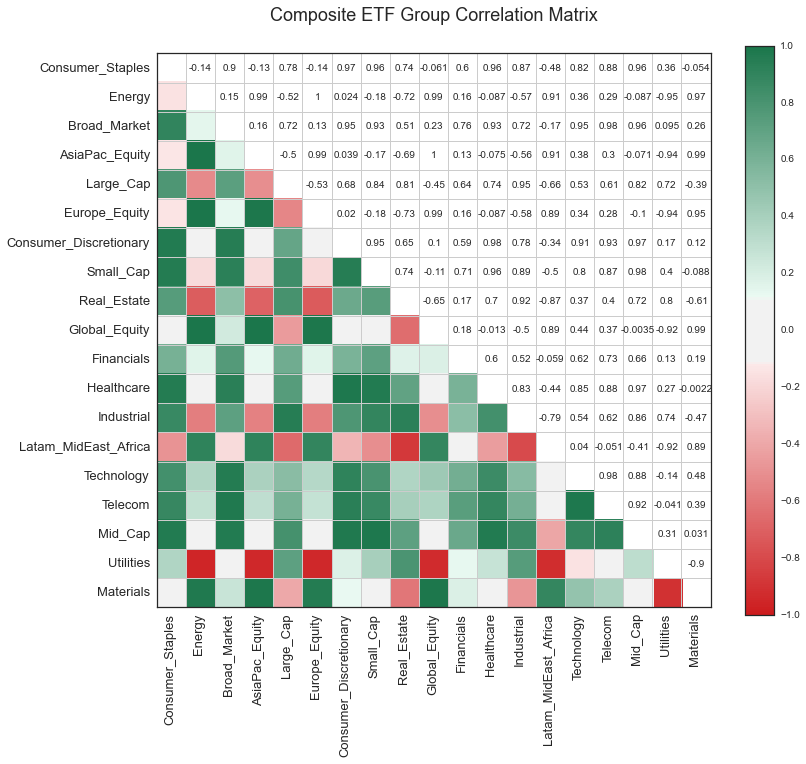

In [8]:
# ================================================================== #
# correlation matrix of composite ETF groups' risk adjusted returns
cor = risk_rets.corr()

# ~~ plot code
f, ax = plt.subplots(figsize=(12,12))

cmap = sns.diverging_palette(h_neg=12, h_pos=144, s=91, l=44, sep=29, n=12, center='light',as_cmap=True)
sns.corrplot(cor, annot=True, sig_stars=False, diag_names=False, cmap=cmap, ax=ax)
ax.set_title('Composite ETF Group Correlation Matrix', fontsize=18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)

f.tight_layout()


Examining the correlation heat map it's clear if you want to add diversification to your portfolio, take a look at Utilities, International equities, and potentially Energy/Basic Materials.

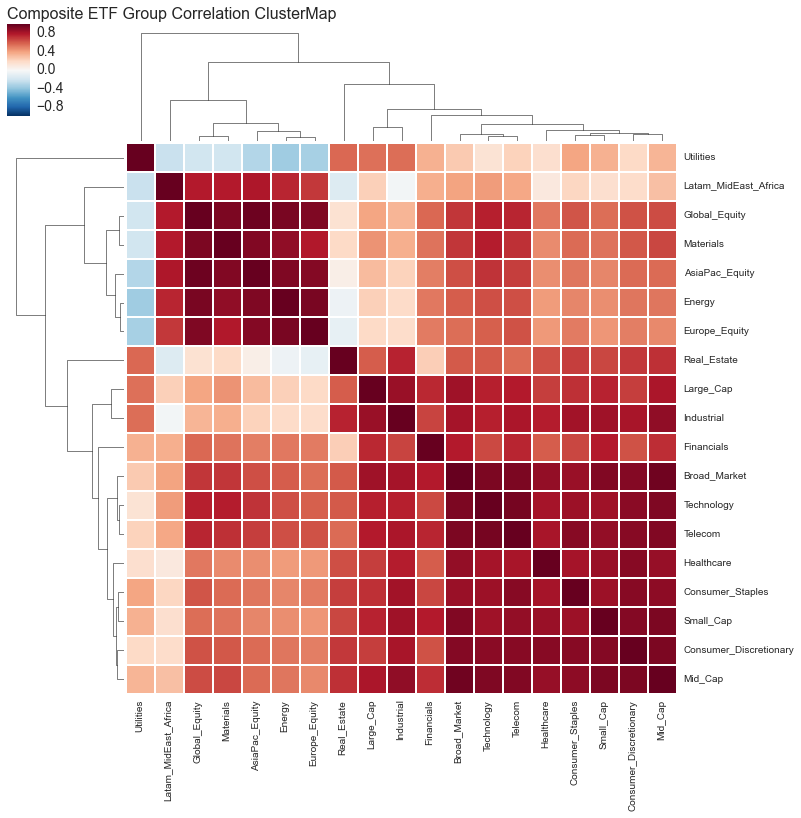

In [9]:
f = plt.figure()
sns.clustermap(cor, figsize=(12,12))
plt.title('Composite ETF Group Correlation ClusterMap', fontsize=16, loc='left')
plt.tick_params(axis='both', labelsize=14)

Note the change in rankings below. 

In [10]:
# ================================================================== #
# import ICC estimates
frame = p.read_csv( filepath+'Spdr_ICC_est_{}.csv'.format(date_today) , index_col=0 ).dropna()
pre_frame = p.read_csv( filepath+'Spdr_ICC_est_2015-05-10.csv', index_col=0 ).dropna() 
# ================================================================== #
# group ICC data by category
f        = frame.copy()
pre_f    = pre_frame[['ETF_ICC_est','Category']]

grp      = f.groupby('Category')
grp_mean = grp.mean().sort('ETF_ICC_est', ascending=False)

pre_grp  = pre_f.groupby('Category')
pre_grp_mean = pre_grp.mean().sort('ETF_ICC_est', ascending=False) 
pre_grp_mean = np.round( pre_grp_mean, 3 )
p.set_option('colheader_justify', 'right')
gm_cols = ['Current ICC Est', 'Rank', 'Previous ICC Est', 'Previous Rank', 'Change in Rank']
grp_mean_rnd = grp_mean['ETF_ICC_est'].round(3)
grp_mean = p.DataFrame( grp_mean_rnd )
grp_mean['Rank'] = grp_mean.rank(ascending=False, method='dense')
grp_mean['Previous ICC est'] = pre_grp_mean
grp_mean['Previous Rank'] = pre_grp_mean.rank(ascending=False, method='dense')
grp_mean['Change in Ranking'] = grp_mean['Previous Rank'] - grp_mean['Rank']
grp_mean.columns = gm_cols
grp_mean

,Current ICC Est,Rank,Previous ICC Est,Previous Rank,Change in Rank
Category,,,,,
Financials,0.235,1,0.242,1,0
Europe_Equity,0.221,2,0.222,2,0
AsiaPac_Equity,0.203,3,0.205,3,0
Energy,0.184,4,0.179,6,2
Utilities,0.183,5,0.191,4,-1
Global_Equity,0.180,6,0.183,5,-1
Materials,0.171,7,0.168,8,1
Latam_MidEast_Africa,0.168,8,0.174,7,-1
Industrial,0.140,9,0.142,9,0


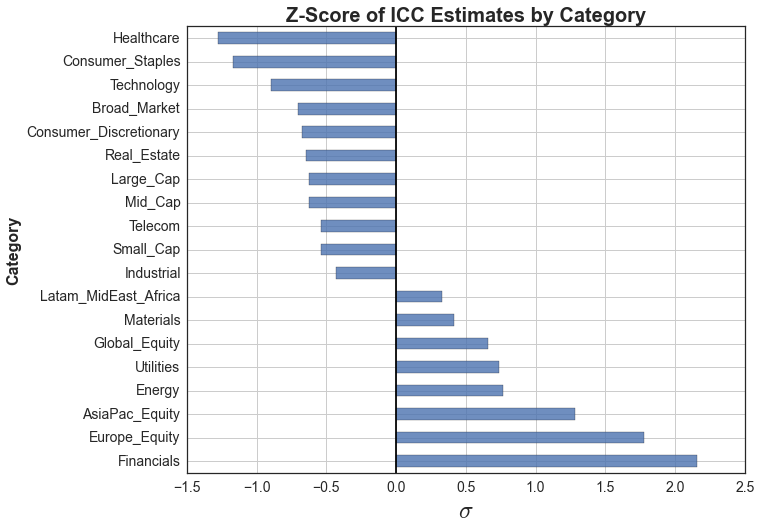

In [11]:
def z_score(df):
    return ( df - df.mean() ) / df.std()

#z_grp = (grp_mean - grp_mean.mean()) / grp_mean.std()
z_grp = z_score(grp_mean['Current ICC Est'])

plt.figure()
size = (10, 8)
z_grp.plot('barh', figsize=size, alpha=.8)
plt.axvline(0, color='k')
plt.title('Z-Score of ICC Estimates by Category', fontsize=20, fontweight='demibold')
plt.xlabel('$\sigma$', fontsize=24)
plt.ylabel('Category', fontsize=16, fontweight='demibold')
plt.tick_params(axis='both', which='major', labelsize=14)


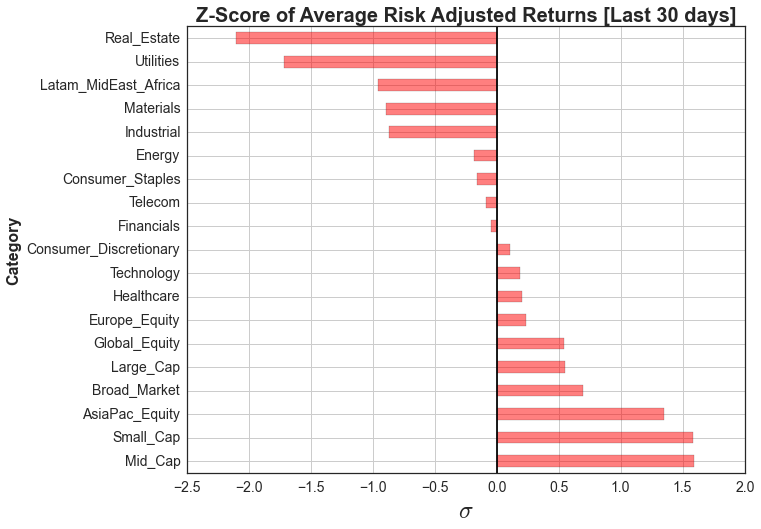

In [12]:
# last 30 days average category risk adjusted returns
date_mask = date_today - 30 * BDay()
l_30 = risk_rets.ix[date_mask:].mean().order(ascending=False) 
l_30

# z scored and plotted
z_l_30 = z_score(l_30)

plt.figure()
z_l_30.plot('barh', figsize=size, color='r', alpha=.5)
plt.axvline(0, color='k')
plt.title('Z-Score of Average Risk Adjusted Returns [Last 30 days]', fontsize=20, fontweight='demibold')
plt.xlabel('$\sigma$', fontsize=24)
plt.ylabel('Category', fontsize=16, fontweight='demibold')
plt.tick_params(axis='both', which='major', labelsize=14)

Looking at the Z-Scores Comparison below, on a relative basis (L/30 days), *Real Estate* and *Utilities* continue to represent a potential "good" relative value. However, the risk there has to do with their interest rate sensitivity. Also interesting to me is the appearance of fair value for *AsiaPac_Equity* as the z-scores are in approximate alignment. 

Style wise, *Small* and *Mid-Cap Equities* have found relative parity but continue to look overvalued. Until proven otherwise my current working theory is that portfolio managers are hedging USD appreciation risk by bidding up domestic firms less exposed to currency movements. Said another way there is a premium on "smaller" firms with the majority of their operating earnings denominated in USD. This premium is likely higher for firms that are in position to exploit the currency differentials by importing their business inputs from countries with declining currencies while showing revenue growth domestically, AND denominated in USD. Evidence of this is in the relative outperformance of *Small/Mid-Cap* vs *Large-Cap* equities.

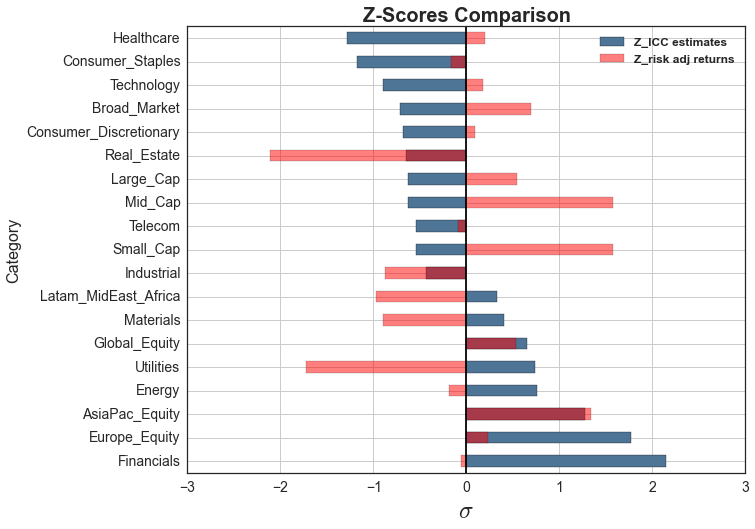

In [13]:
z_data = p.DataFrame()
z_data['Z_ICC estimates'] = z_grp
z_data['Z_risk adj returns'] = z_l_30
# z_data.head()

cadet_blue = '#4e7496'

fig = plt.figure()
with p.plot_params.use('x_compat', True):
    z_data['Z_ICC estimates'].plot('barh', figsize=size, color=cadet_blue)
    z_data['Z_risk adj returns'].plot('barh',figsize=size, color='r', alpha=.5)
plt.axvline(0, color='k')
plt.title('Z-Scores Comparison', fontsize=20, fontweight='demibold')
plt.xlabel('$\sigma$', fontsize=24, fontweight='demibold')
plt.ylabel('Category', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc='best', prop={'weight':'demibold','size':12})

Early patterns in this cumulative return analysis show mild rotational/mean reverting behavior between top and bottom performing composite sectors. Last update featured *AsiaPac Equity, Real-Estate, and Healthcare* as 3 of the worst performing sectors, while 2/3 (AsiaPac, Healthcare) are the best performing sectors over the most recent time period. 

*Europe Equity, Energy, and Materials* were the top 3 performing sectors in the last update, while all 3 corrected a bit since, *Energy* and *Materials* are 2/3 of the worst performing composite sectors during the most recent period. 

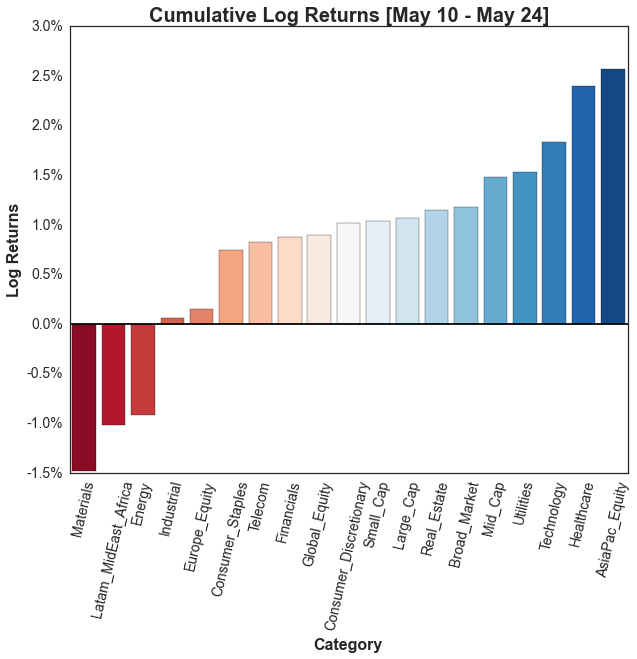

In [14]:
# ================================================================== #
# construct dataframe and proper multi index
log_rets_recent = np.log( px.ix['5/10/2015':] / px.ix['5/10/2015':].shift(1) ).dropna()

lrets_recent = log_rets_recent.T.copy()
lrets_recent.index.name = 'ETF'
lrets_recent['Category'] = p.Series()

for cat_key, etf_val in cat.items():
    for val in etf_val:
        if val in lrets_recent.index:
            idx_loc = lrets_recent.index.get_loc(val)
            lrets_recent.ix[idx_loc,'Category'] = cat_key
        else:
            pass

lrets_recent.set_index('Category', append=True, inplace=True)
lrets_recent = lrets_recent.swaplevel('ETF','Category').sortlevel('Category')
lrets_recent.head()       

# ================================================================== #
# cumulative returns of ETF's
cum_rets_recent = lrets_recent.groupby(level='Category').cumsum(axis=1)
cum_rets_recent.head();

# ================================================================== #
# composite groupings of cumulative ETF returns (equally weighted intra-category mean returns)
composite_rets_recent = p.DataFrame()
for label in cat.keys():
    composite_rets_recent[label] = cum_rets_recent.ix[label].mean(axis=0) # equal weighted mean
    
crr = np.round(composite_rets_recent.copy(),4) # rounding
#fig = plt.figure()
#comp_rets_recent.ix[-1:].plot(kind='bar', figsize=size)
#comp_rets_recent
#crr = crr.reset_index()
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import matplotlib
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)
    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] == True:
        return s + r'$\%$'
    else:
        return s + '%'

# Create the formatter using the function to_percent. This multiplies all the
# default labels by 100, making them all percentages
formatter = FuncFormatter(to_percent)

f = plt.figure(figsize=size)
# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)
bar_rets = crr.ix[-1:].T.sort( '{}'.format(date_today - 1 * BDay()) )
bar_rets = bar_rets.reset_index()
cols = ['index', 'log_rets_2wk']
bar_rets.columns = cols
#bar_rets.head()
plt.xticks(rotation=77)
plt.axhline(0, color='k')
plt.title('Cumulative Log Returns [May 10 - May 24]', fontsize=20, fontweight='demibold')
sns.barplot( x=bar_rets.index, y=bar_rets['log_rets_2wk'], data=bar_rets.sort('log_rets_2wk'), palette='RdBu')
plt.xticks(bar_rets.index, bar_rets['index'])
plt.xlabel('Category', fontsize=16, fontweight='demibold')
plt.ylabel('Log Returns', fontsize=16, fontweight='demibold')
plt.tick_params(axis='both', which='major', labelsize=14)

In [15]:
br = crr.ix[-1:].T.sort( '{}'.format(date_today - 1 * BDay()) )
br['Rank'] = crr.ix[-1:].T.sort( '{}'.format(date_today - 1 * BDay()) ).rank(method='dense',ascending=False)
cols = ['Cum. log returns [5.10-5.24]','Rank']
sortd = br.sort('Rank',ascending=True)
sortd.columns = cols
sortd.index.name = 'Category'
sortd

,Cum. log returns [5.10-5.24],Rank
Category,,
AsiaPac_Equity,0.0257,1
Healthcare,0.0240,2
Technology,0.0183,3
Utilities,0.0153,4
Mid_Cap,0.0148,5
Broad_Market,0.0118,6
Real_Estate,0.0115,7
Large_Cap,0.0107,8
Small_Cap,0.0104,9


# Interpretation
---
### Potential Long Positions:
___
- **Neutral bias:** The compression in rolling risk-adjusted returns, and general lack of conviction overall has left me wanting more information to determine any appropriate positioning. 
 
### Potential Short Positions:
___
 - **Neutral bias:** See above. 
 
### Notes:
___
 - **Mid Caps, Small Caps:** Style wise it's difficult to bet against Mid Caps due the diversity of businesses and the general stage of growth a Mid Cap firm is likely to find itself in. Historically Small Caps have shown more sensitivity to general market conditions. However, there may be a divergence from historical patterns because of `USD` strength. Logically, Small Cap firms are more likely to be domestic firms that primarily earn revenue denominated in `USD`, while Large Caps in particular, are more exposed to currency fluctuations as large components of their operating revenue may be denominated in currencies that are weaknening against the `USD`. My current investing thesis is that Mid Cap and Small Cap equities are trading/valued on a similar basis - Less earnings sensitivity to USD appreciation.

_I conclude this analysis with the disclaimer that these calculations are presented `"as is"` and the data was aggregated from several sources. I recommend doing your own due diligence before taking any investment action and to stay within your personal risk/return objectives._ 

_I expect to refine this model as necessary to improve its utility as a macro valuation tool. Please contact me to report any errors._ 


####**For comments, questions, and feedback contact me via:**
####email:   **`bcr@blackarbs.com`** 
####twitter: **`@blackarbsCEO`**
___

_**Data Sources:** [Yahoo Finance](http://finance.yahoo.com/), [S&P SPDR ETFs](https://www.spdrs.com/product/)_<br />_**Acknowledgements:** Ipython Notebook styling modded from Plotly and Cam Davidson-Pilon custom CSS_

In [16]:
from IPython.core.display import HTML 

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [17]:
from IPython.core.display import HTML 
import requests

styles = requests.get("https://raw.githubusercontent.com/BlackArbsCEO/BlackArbsCEO.github.io/Equity-Analysis/Equity%20Analysis/custom.css")
HTML(styles.text)